Vysvetliteľná metóda Grad-CAM

In [13]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/data/new_merged.csv"

df = pd.read_csv(csv_path)

#ukážka dát
print("Prvých 5 riadkov dát:")
print(df.head())

texts = df["text"].tolist()
image_paths = df["img"].tolist()
labels = df["label"].tolist()


print("Načítaných textov:", len(texts))
print("Načítaných ciest k obrázkom:", len(image_paths))
print("Načítaných labelov:", len(labels))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Prvých 5 riadkov dát:
   Unnamed: 0.1  Unnamed: 0     id  \
0             0           0  42953   
1             1           1  23058   
2             2           2  13894   
3             3           3  37408   
4             4           4  82403   

                                            Fulltext  \
0  its their character not their color that matte...   
1  don't be afraid to love again everyone is not ...   
2  putting bows on your pet  [[], ['Korat', 'Russ...   
3  i love everything and everybody! except for sq...   
4  everybody loves chocolate chip cookies, even h...   

                                                text            img  label  \
0   its their character not their color that matters  img/42953.png      0   
1  don't be afraid to love again everyone is not ...  img/23058.png      0   
2                           putting bows on your 

In [3]:
import torch

#načítanie checkpointu
model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"

checkpoint = torch.load(model_path, map_location="cpu")

#dostupné kľúče v checkpointe
print("Dostupné kľúče v checkpointe:", checkpoint.keys())

#vypísanie prvých vrstiev
if "model_state_dict" in checkpoint:
    state_dict = checkpoint["model_state_dict"]
    print("\nPrvých 10 kľúčov v state_dict:")
    for i, key in enumerate(state_dict.keys()):
        if i >= 10:
            break
        print(key)
elif isinstance(checkpoint, dict):
    print("\nCheckpoint neobsahuje 'model_state_dict', ale má tieto kľúče:")
    for key in checkpoint.keys():
        print(key)
else:
    print("\nCheckpoint nie je dict. Možno bol uložený ako celý model.")



Dostupné kľúče v checkpointe: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict'])

Prvých 10 kľúčov v state_dict:
features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.0.1.running_mean


In [4]:
import torch
import torchvision.models as models

#definovanie modelu
model = models.mobilenet_v2()

# Načítanie checkpointu
checkpoint = torch.load("/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth", map_location="cpu")

#načítanie váh modelu
model.load_state_dict(checkpoint["model_state_dict"], strict=False)

model.eval()

print("Model bol úspešne načítaný.")


Model bol úspešne načítaný.


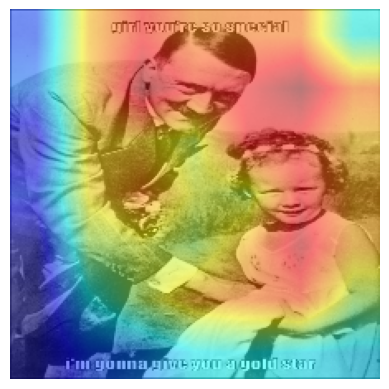

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#cesta k checkpointu a obrázku
model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01349.png"

#definovanie modelu
model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()

#funkcia na spracovanie obrázka
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

#trieda Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber poslednej konvolučnej vrstvy
layer_name = model.features[-1]
grad_cam = GradCAM(model, layer_name)

#spracovanie obrázka
input_tensor = preprocess_image(image_path)

#generovanie Grad-CAM
cam = grad_cam.generate_cam(input_tensor)

#zobrazenie výsledku
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

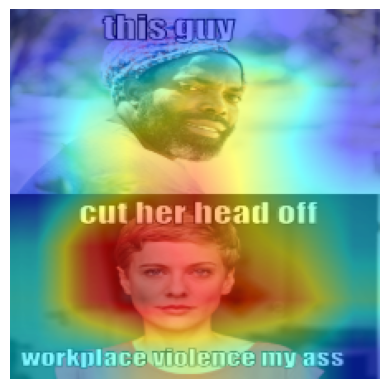

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01698.png"

model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam


layer_name = model.features[-1]
grad_cam = GradCAM(model, layer_name)


input_tensor = preprocess_image(image_path)


cam = grad_cam.generate_cam(input_tensor)


image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

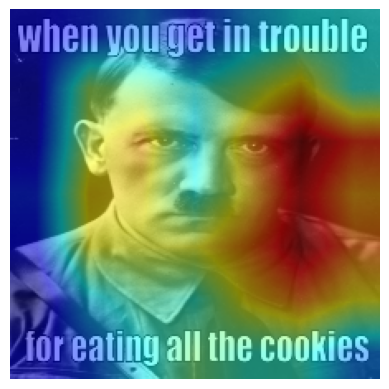

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01874.png"


model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

#Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber poslednej konvolučnej vrstvy
layer_name = model.features[-1]
grad_cam = GradCAM(model, layer_name)


input_tensor = preprocess_image(image_path)


cam = grad_cam.generate_cam(input_tensor)

#zobrazenie výsledku
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


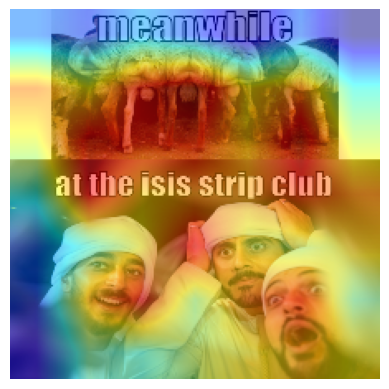

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/02947.png"


model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

#Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber poslednej konvolučnej vrstvy
layer_name = model.features[-2]
grad_cam = GradCAM(model, layer_name)


input_tensor = preprocess_image(image_path)


cam = grad_cam.generate_cam(input_tensor)

#zobrazenie výsledku
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

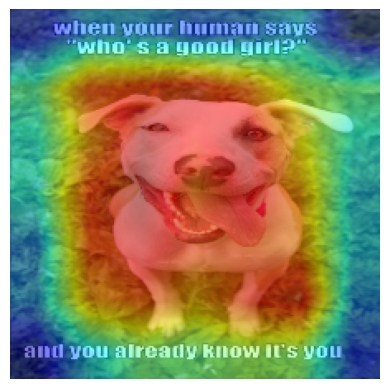

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01243.png"


model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

#Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber poslednej konvolučnej vrstvy
layer_name = model.features[-1]
grad_cam = GradCAM(model, layer_name)


input_tensor = preprocess_image(image_path)


cam = grad_cam.generate_cam(input_tensor)

#zobrazenie výsledku
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

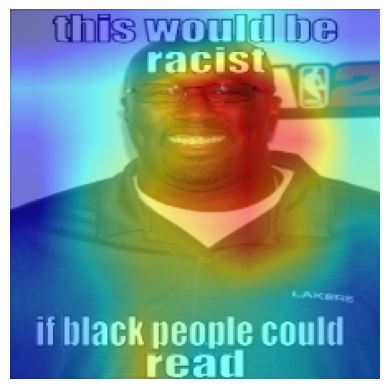

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01642.png"


model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

#Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber poslednej konvolučnej vrstvy
layer_name = model.features[-1]
grad_cam = GradCAM(model, layer_name)

#spracovanie obrázka
input_tensor = preprocess_image(image_path)


cam = grad_cam.generate_cam(input_tensor)

#zobrazenie výsledku
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

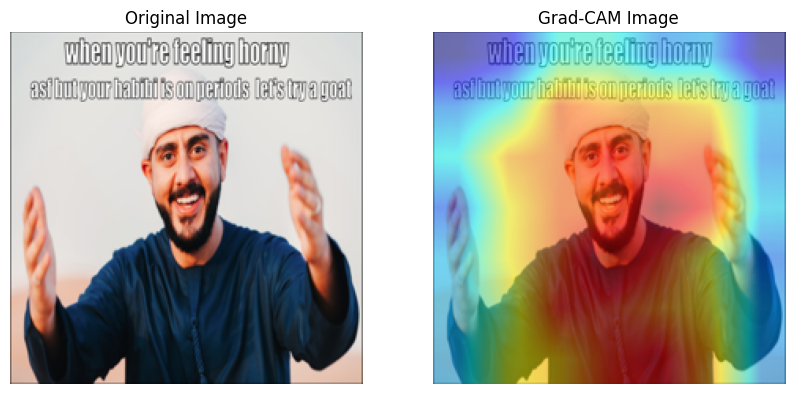

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01235.png"


model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), np.array(image.resize((224, 224)))

#Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber poslednej konvolučnej vrstvy
layer_name = model.features[-1]
grad_cam = GradCAM(model, layer_name)


input_tensor, original_image = preprocess_image(image_path)


cam = grad_cam.generate_cam(input_tensor)

#vytvorenie heatmapy
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("Grad-CAM Image")
ax[1].axis("off")
plt.show()

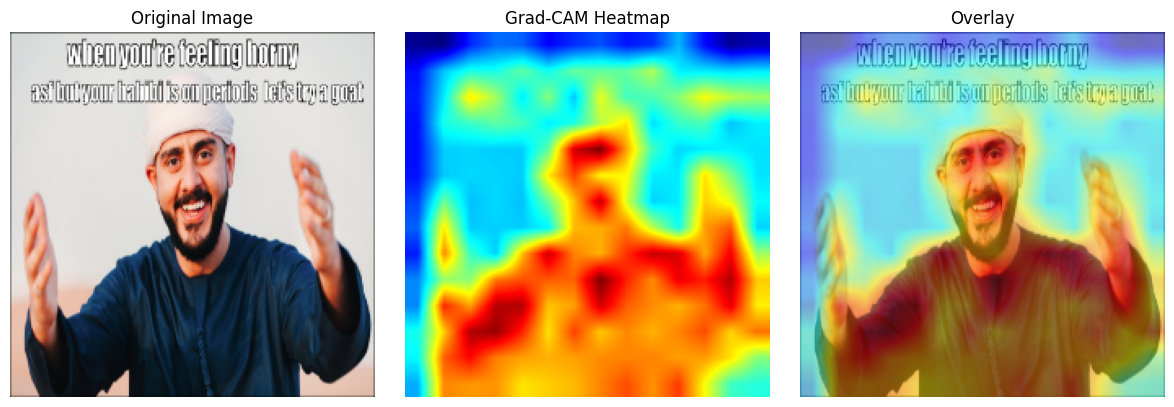

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250222-070948.pth"
image_path = "/content/drive/MyDrive/img/01235.png"


model = models.mobilenet_v2()
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

#Grad-CAM trieda
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        cam = torch.mean(self.activation, dim=1).squeeze().detach().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

#vyber konvolučnej vrstvy 10
layer_name = model.features[10]
grad_cam = GradCAM(model, layer_name)

input_tensor = preprocess_image(image_path)

cam = grad_cam.generate_cam(input_tensor)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image = cv2.resize(original_image, (224, 224))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


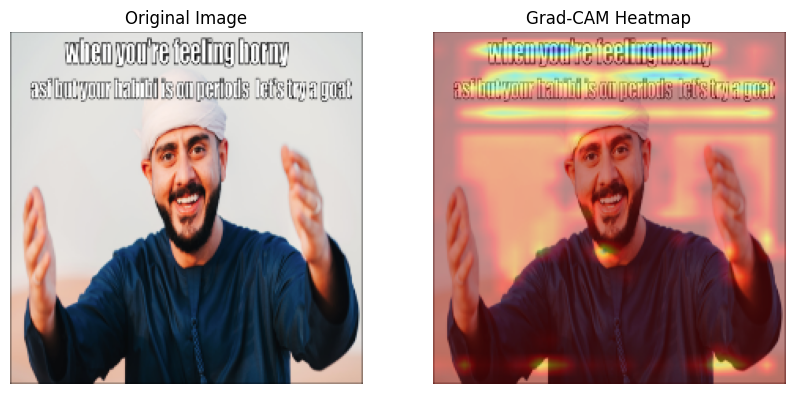

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import cv2
import numpy as np
import matplotlib.pyplot as plt

#načítanie modelu
model_path = "/content/drive/MyDrive/Checkpointss/resnet_checkpoint_20250218-164930.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#definícia modelu
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

#načítanie váh
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()


image_path = "/content/drive/MyDrive/img/01235.png"
orig_img = cv2.imread(image_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
orig_img = cv2.resize(orig_img, (224, 224))


input_tensor = transforms.ToTensor()(orig_img.astype(np.float32) / 255.0).unsqueeze(0).to(device)
input_tensor.requires_grad = True

#GRAD-CAM funkcia
def compute_gradcam(model, input_tensor, target_layer_name="layer4.2"):
    activations = None
    gradients = None

    target_layer = dict(model.named_modules())[target_layer_name]

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out  # (N, C, H, W)

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]  # (N, C, H, W)

    #hooky
    fwd = target_layer.register_forward_hook(forward_hook)
    bck = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    loss = output[0,0]

    model.zero_grad()
    loss.backward()

    fwd.remove()
    bck.remove()

    activations = activations[0]
    gradients = gradients[0]

    pooled_grads = torch.mean(gradients, dim=[1,2], keepdim=True)
    weighted_activations = activations * pooled_grads
    heatmap = torch.mean(weighted_activations, dim=0).detach().cpu().numpy()

    #ReLU a normalizácia
    heatmap = np.maximum(heatmap, 0)
    max_val = heatmap.max()
    if max_val != 0:
        heatmap /= max_val

    return heatmap

def display_gradcam(orig_img, heatmap, alpha=0.4):
    if orig_img.dtype != np.uint8:
        display_img = orig_img.astype(np.uint8)
    else:
        display_img = orig_img.copy()

    #zmeníme heatmapu na (H,W,3)
    heatmap_resized = cv2.resize(heatmap, (display_img.shape[1], display_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    #spojenie
    superimposed_img = cv2.addWeighted(display_img, 1 - alpha, heatmap_resized, alpha, 0)

    #vykreslenie
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(display_img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed_img)
    plt.axis("off")

    plt.show()

#iné vrstvy ešte layer3.5.conv3 alebo layer4.2.conv3
gradcam_layer = "layer2.3.conv3"
heatmap = compute_gradcam(model, input_tensor, target_layer_name=gradcam_layer)

display_gradcam(orig_img, heatmap, alpha=0.4)